<a href="https://colab.research.google.com/github/SaiSanthosh1508/Brain-Tumour-Image-classification-app/blob/main/08_Replicating_Research_Paper_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08.PyTorch Paper Replicating

## 0. Get Setup

Let's import code we previously written and required libraries

In [1]:
import torch
import torchvision

print(torch.__version__)
torchvision.__version__

2.4.1+cu121


'0.19.1+cu121'

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [7]:
from torchvision import transforms
IMG_SIZE = (224,224)

manual_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
BATCH_SIZE = 32
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                           test_dir=test_dir,
                                                                           transform=manual_transforms,
                                                                           batch_size=BATCH_SIZE)
train_dataloader,test_dataloader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x79669b3abca0>,
 ['pizza', 'steak', 'sushi'])

In [9]:
len(train_dataloader),len(test_dataloader)

(8, 3)

In [10]:
len(train_dataloader.dataset),len(test_dataloader.dataset)

(225, 75)

### 2.3 Visualize a single image

(-0.5, 223.5, 223.5, -0.5)

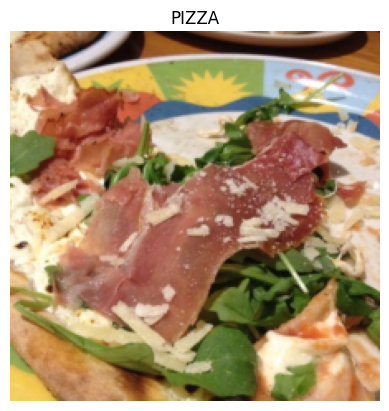

In [11]:
# Get a batch of images
images,labels = next(iter(train_dataloader))

# Get a single image and label from the batch
image,label = images[0],labels[0]

# Plot the image
image.shape,label
plt.imshow(image.permute([1,2,0]))
plt.title((class_names[label]).upper())
plt.axis('off')

## 3. Replicating ViT: Overview

* **Inputs** - What goes into the model?
* **Outputs** - What comes out of the model/layer/block ?
* **Layers** -  Takes an input,manipulates it with a function(for example it could be self attention layers)
* **Blocks** - A collection of layers.
* **Model** - A collection of blocks.

## 4. Equation 1:Split data into patched and creating the class,position and patch embedding

In [12]:
# Create example values

height = 224
width = 224
patch_size = 16
channels = 3

# Calculate the number of patches
number_of_patches = int(height * width / patch_size ** 2)
number_of_patches

196

In [13]:
# Input shape
embedding_layer_input_shape = (height,width,channels)

# Output shape
emebdding_layer_output_shape = (number_of_patches,patch_size**2 * channels)

print(f"Input shape : {embedding_layer_input_shape}")
print(f"Output shape : {emebdding_layer_output_shape}")

Input shape : (224, 224, 3)
Output shape : (196, 768)


### 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

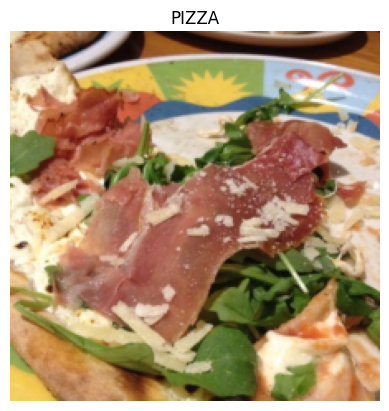

In [14]:
plt.imshow(image.permute([1,2,0]))
plt.title((class_names[label]).upper())
plt.axis('off')

In [15]:
image.shape

torch.Size([3, 224, 224])

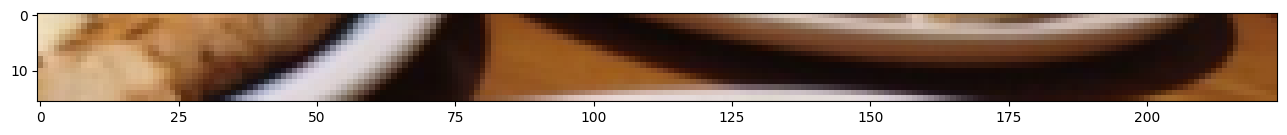

In [16]:
# Get the top row of the image
image_permuted = image.permute(1,2,0)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size])

Number of patches per row: 14.0
Number of patches per image: 196.0


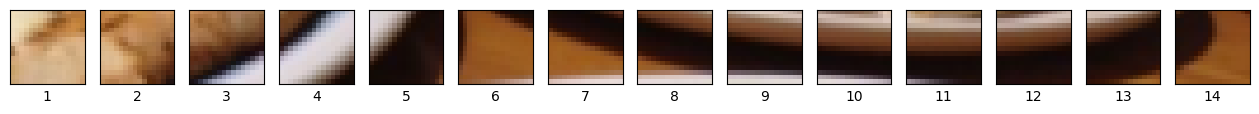

In [17]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0,"Image size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}\nNumber of patches per image: {num_patches ** 2}")

# Create a series of subplots
fig,axs = plt.subplots(nrows=1,
                       ncols=img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size,patch_size))

# Iterate through the number of patches in the top row
for i,patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row:14.0      
 Number of patches per col ;14.0       
 Total number of patches : 196.0


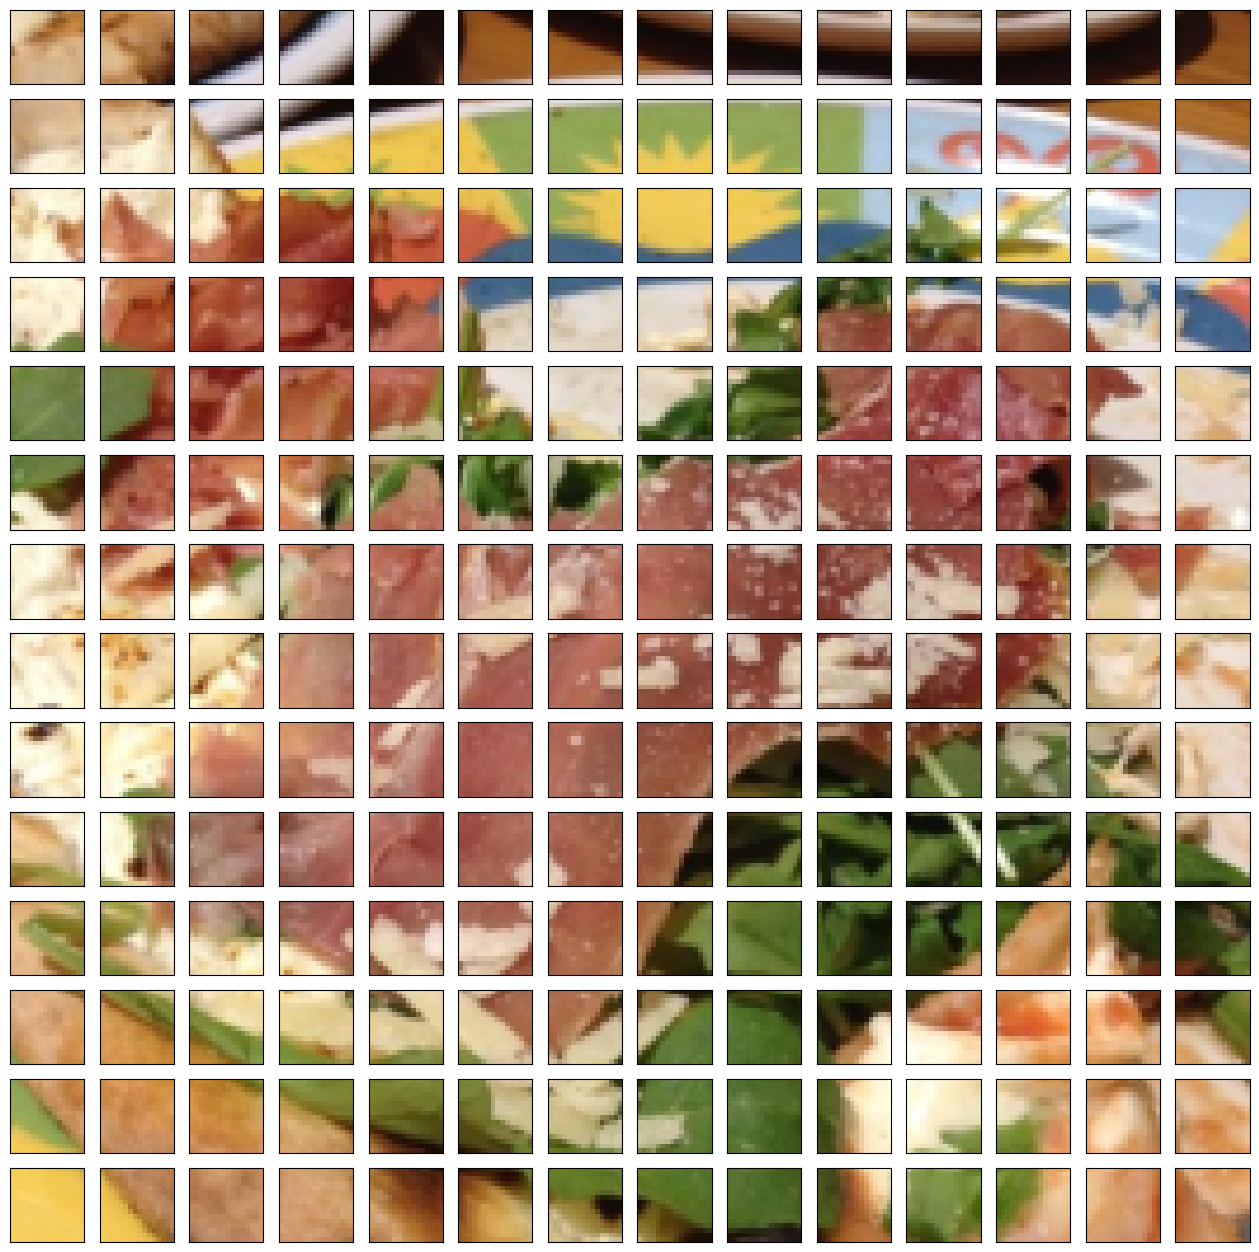

In [18]:
# Setup code to plot whole image as patched
img_size = 224
patch_size = 16
num_patches = img_size / patch_size

assert img_size % patch_size == 0,"Image size must be divisible by patch_size"

print(f"Number of patches per row:{num_patches}\
      \n Number of patches per col ;{num_patches} \
      \n Total number of patches : {num_patches ** 2}")

# Create a series of sub plots
fix,axs = plt.subplots(nrows=img_size // patch_size,
                       ncols=img_size // patch_size,
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size,patch_size))

# loop through the height and width of the image
for i,patch_height in enumerate(range(0,img_size,patch_size)):
  for j,patch_width in enumerate(range(0,img_size,patch_size)):
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,patch_width:patch_width+patch_size,:])
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    # axs[i,j].set_xlabel(f"{i+1},{j+1}")
    # axs[i,j].set_ylabel(f"{i+1},{j+1}")
    # axs[i,j].set_title(f"{i+1},{j+1}")


### 4.3 Creating image patches and turning them into patch embeddings

In [19]:
# Create a Conv2d layer to turn image into patch embeddings

from torch import nn

# Set the patch size
patch_size = 16

# Create a Conv2d layer
conv2d = nn.Conv2d(in_channels = 3,
                   out_channels = 768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

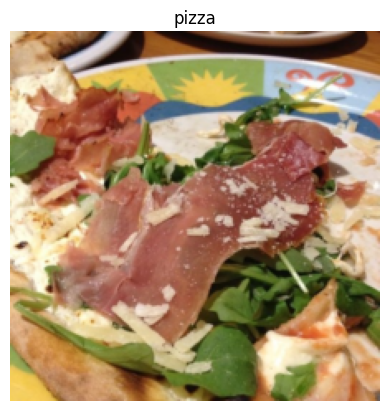

In [20]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')

In [21]:
# Pass the image through conv2d layer

image_out_of_conv  = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [107, 80, 479, 266, 305]


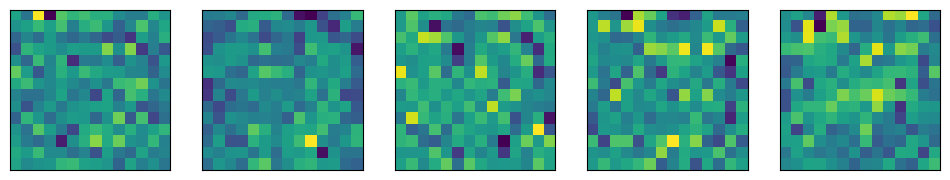

In [22]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [23]:
# Get a single feature map in tensor form

single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.4821, -0.1266, -0.1912, -0.2671, -0.3564, -0.1380, -0.0208,
           -0.0143, -0.2535, -0.3239, -0.2381, -0.2131, -0.3842, -0.0108],
          [-0.3871, -0.3116, -0.5175, -0.2526, -0.0009, -0.4804, -0.4850,
           -0.4293, -0.4404, -0.5403, -0.4624, -0.2036, -0.0800, -0.3145],
          [-0.3309, -0.3499, -0.3083, -0.1751, -0.1976, -0.2639, -0.2897,
           -0.2482, -0.3154, -0.4567, -0.4436, -0.8028, -0.5704, -0.5969],
          [-0.5528, -0.2715, -0.1763, -0.1576, -0.2355, -0.3448, -0.3217,
           -0.3718, -0.2882, -0.1530, -0.0541, -0.2770, -0.5355, -0.4687],
          [-0.3012, -0.1863, -0.0858, -0.1653, -0.2599, -0.4081, -0.5699,
           -0.3595, -0.2780, -0.2922, -0.2205, -0.1220, -0.3989, -0.4827],
          [-0.2313, -0.0283, -0.1841, -0.3250, -0.2377, -0.0751, -0.3603,
           -0.1272, -0.2087, -0.2102, -0.1268, -0.2805, -0.4754, -0.5605],
          [-0.6209, -0.1028, -0.4234, -0.2745, -0.1842, -0.3878, -0.2416,
           -0.2202, -0.2803, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

In [24]:
print(f"This is the shape before flattening:{image_out_of_conv.shape}")

This is the shape before flattening:torch.Size([1, 768, 14, 14])


Want: [batch_size,number_of_patches,embedding_dim]

In [27]:
from torch import nn

flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flattend_image_out_of_cov = flatten_layer(image_out_of_conv)

original image shape:{image.shape}
Image feature map shape:torch.Size([1, 768, 14, 14])


NameError: name 'flattened_image_out_of_conv' is not defined

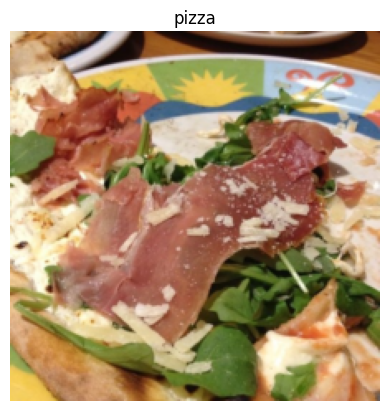

In [28]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')
print("original image shape:{image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape:{image_out_of_conv.shape}")

# Flatten feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape:{flattened_image_out_of_conv.shape}")


In [29]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


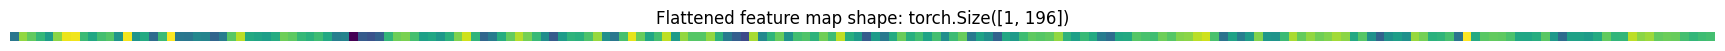

In [30]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Turning the ViT patch embedding layer into PyTorch module

In [35]:
class PatchEmbedding(nn.Module):
  """
  Turns image into patch embeddings
  """
  def __init__(self,
               in_channels:int = 3,
               patch_size:int = 16,
               embedding_dim:int = 768):
    super().__init__()

    # Create a layer to turn image into embedding patches
    self.patcher = nn.Conv2d(in_channels = in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride=patch_size,
                             padding=0)

    # Flatten the feature map dimensions
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self,x):

      image_resolution = x.shape[-1]
      assert image_resolution%patch_size == 0,f"Input image size must be divisible by patch size"
      x  = self.patcher(x)
      x = self.flatten(x)
      return x

      # make sure returned sequence embedding are in right order
      return x.permute(0,2,1)



In [36]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels = 3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image size : {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output image size : {patch_embedded_image.shape}")

Input image size : torch.Size([1, 3, 224, 224])
Output image size : torch.Size([1, 768, 196])


In [39]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250)

patchify(rand_image_tensor)

tensor([[[ 0.2489, -0.1637,  0.8539,  ..., -0.1456, -0.6896,  0.1886],
         [-0.7311, -0.4349,  0.4310,  ...,  0.5529, -0.0747,  0.4369],
         [-1.7778, -0.0081,  0.0947,  ...,  0.2347, -0.1778,  0.8663],
         ...,
         [-0.5967,  0.4155, -0.1479,  ..., -1.2069,  0.3013,  0.1503],
         [-0.1773, -0.6881,  0.8442,  ...,  0.6135,  0.3928,  0.3466],
         [-0.0036,  0.5905,  1.3280,  ..., -0.0321,  0.3277, -0.4518]]],
       grad_fn=<ViewBackward0>)

### 4.6 Creating a class token embedding

In [42]:
patch_embedded_image = patch_embedded_image.permute(0,2,1)

In [43]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [44]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[2]
num_patches = patch_embedded_image.shape[1]

print(f"Batch size : {batch_size}")
print(f"Embedding dimension : {embedding_dimension}")
print(f"Number of patches : {num_patches}")

Batch size : 1
Embedding dimension : 768
Number of patches : 196


In [46]:
# Create calss token embedding as a learnable parameter

class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [47]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [48]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat([class_token,patch_embedded_image],dim=1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

### 4.6 Creating the class token embedding

In [49]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.5790,  0.0393, -0.2685,  ...,  0.5292, -0.3765,  0.2694],
         [-0.3946,  0.0641, -0.0593,  ...,  0.2506, -0.2438,  0.2389],
         [-0.5289,  0.2368, -0.1775,  ...,  0.3145, -0.2675,  0.1206],
         ...,
         [-0.7389,  0.2119, -0.2228,  ...,  0.5117, -0.3406,  0.0206],
         [-0.6463,  0.0476, -0.1423,  ...,  0.4339, -0.3897,  0.2332],
         [-0.6455,  0.1361, -0.1384,  ...,  0.4088, -0.3225,  0.1739]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [50]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [51]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.5790,  0.0393, -0.2685,  ...,  0.5292, -0.3765,  0.2694],
         [-0.3946,  0.0641, -0.0593,  ...,  0.2506, -0.2438,  0.2389],
         ...,
         [-0.7389,  0.2119, -0.2228,  ...,  0.5117, -0.3406,  0.0206],
         [-0.6463,  0.0476, -0.1423,  ...,  0.4339, -0.3897,  0.2332],
         [-0.6455,  0.1361, -0.1384,  ...,  0.4088, -0.3225,  0.1739]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.7 Creating a position embedding

In [52]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.5790,  0.0393, -0.2685,  ...,  0.5292, -0.3765,  0.2694],
          [-0.3946,  0.0641, -0.0593,  ...,  0.2506, -0.2438,  0.2389],
          ...,
          [-0.7389,  0.2119, -0.2228,  ...,  0.5117, -0.3406,  0.0206],
          [-0.6463,  0.0476, -0.1423,  ...,  0.4339, -0.3897,  0.2332],
          [-0.6455,  0.1361, -0.1384,  ...,  0.4088, -0.3225,  0.1739]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [53]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [54]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4210, 1.0393, 0.7315,  ..., 1.5292, 0.6235, 1.2694],
         [0.6054, 1.0641, 0.9407,  ..., 1.2506, 0.7562, 1.2389],
         ...,
         [0.2611, 1.2119, 0.7772,  ..., 1.5117, 0.6594, 1.0206],
         [0.3537, 1.0476, 0.8577,  ..., 1.4339, 0.6103, 1.2332],
         [0.3545, 1.1361, 0.8616,  ..., 1.4088, 0.6775, 1.1739]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


### 4.8 Putting it all together: image to embedding

In [56]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x).permute(0,2,1)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Self Attention

In [57]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [58]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 6. Equation 3: Multilayer Perceptron (MLP)

In [59]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [60]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


## 7. Create Transformer Encoder

In [61]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

### 7.1 Create a custom transformer encoder block

In [63]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a transformer encoder layer with inbuilt pytorch layer

In [64]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

## 8. Putting it all together  to create ViT

In [65]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [66]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


## 8.2 Getting Visual summary of ViT

In [69]:
# from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
# summary(model=vit,
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [71]:
# from going_modular.going_modular import engine

# # Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
# optimizer = torch.optim.Adam(params=vit.parameters(),
#                              lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
#                              betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
#                              weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# # Setup the loss function for multi-class classification
# loss_fn = torch.nn.CrossEntropyLoss()

# # Set the seeds
# set_seeds()

# # Train the model and save the training results to a dictionary
# results = engine.train(model=vit,
#                        train_dataloader=train_dataloader,
#                        test_dataloader=test_dataloader,
#                        optimizer=optimizer,
#                        loss_fn=loss_fn,
#                        epochs=10,
#                        device=device)